# All Machine learning model code in the project

## Exponential Smoothing (ETS) (Tài)

In [1]:
  !pip install statsmodels==0.14.0

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.1/10.1 MB 58.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 233.8/233.8 KB 38.2 MB/s eta 0:00:00
You should consider upgrading via the '/root/venv/bin/python -m pip install --upgrade pip' command.


In [2]:
#code here
import matplotlib.pyplot as plt
import random
import pandas as pd
import numpy as np
import datetime
import json 
from json import loads
import time
import logging
logging.getLogger("pytorch_lightning").setLevel(logging.WARNING)
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.model_selection import train_test_split
%matplotlib inline
from statsmodels.tsa.exponential_smoothing.ets import ETSModel

In [3]:
df = pd.read_csv('/work/project/AtlanticHalibut.csv',parse_dates=['Last_catch_date'])
df1 = pd.DataFrame()
df1['Date'] = pd.date_range(start = '2000-01-01', end = '2023-05-27' )
df1['Product_weight'] = df1['Date'].apply(lambda x: df.loc[df['Last_catch_date']==x,'Product_weight'].values[0]
                                          if df.loc[df['Last_catch_date']==x,'Product_weight'].shape[0] == 1 else None)
# xử lý missing
df1['Product_weight'] = df1['Product_weight'].interpolate(method='linear').fillna(method='bfill')

# convert kg to ton
df1['Product_weight'] = df1['Product_weight']/1000

df1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8548 entries, 0 to 8547
Data columns (total 2 columns):
 #   Column          Non-Null Count  Dtype         
---  ------          --------------  -----         
 0   Date            8548 non-null   datetime64[ns]
 1   Product_weight  8548 non-null   float64       
dtypes: datetime64[ns](1), float64(1)
memory usage: 133.7 KB


<AxesSubplot: xlabel='Date'>

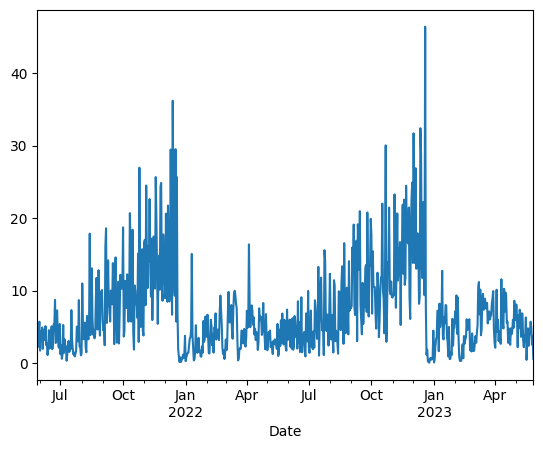

In [5]:
df1.set_index('Date')['Product_weight'][-365*2:].plot()

In [4]:
from sklearn.preprocessing import StandardScaler

#chia dataset thành train_val_test
def split_train_val_test(df, train_size = 0.7, val_size = 0.1, test_size = 0.2):
  train,test = train_test_split(df,train_size=train_size,shuffle=False)
  val,test = train_test_split(test,train_size= val_size/(1-train_size),shuffle=False)
  return train,val, test

def roll_back(df, lb = 14, hz = 14):
  X,y = np.empty([0,lb]), np.empty([0,hz])
  aset = df['Product_weight'].values
  for i in range(len(aset)-lb-hz+1):
    a = aset[i:i+lb].reshape(1,-1)
    b = aset[i+lb:i+lb+hz].reshape(1,-1)
    X = np.append(X,a,axis=0)
    y = np.append(y,b,axis=0)
  return X,y

lookback = 90
horizon = 30

train,val,test = split_train_val_test(df1, train_size = 0.7, val_size = 0.1, test_size = 0.2)
scaler = StandardScaler()
train['Product_weight'] = scaler.fit_transform(train['Product_weight'].values.reshape(-1,1))
val['Product_weight'] = scaler.transform(val['Product_weight'].values.reshape(-1,1))
test['Product_weight'] = scaler.transform(test['Product_weight'].values.reshape(-1,1))

X_train,y_train = roll_back(train, lb = lookback, hz = horizon)
X_val,y_val = roll_back(val, lb = lookback, hz = horizon)
X_test,y_test = roll_back(test, lb = lookback, hz = horizon)
X_30days = test.iloc[-90:,1].values.reshape(1,-1)

X_30days_unscale = scaler.inverse_transform(X_30days)
X_val_unscale = scaler.inverse_transform(X_val)
X_test_unscale = scaler.inverse_transform(X_test)
X_train_unscale = scaler.inverse_transform(X_train)

y_train_unscale = scaler.inverse_transform(y_train)
y_val_unscale = scaler.inverse_transform(y_val)
y_test_unscale = scaler.inverse_transform(y_test)

In [6]:
import matplotlib.pyplot as plt

def visualize(test,X_test_unscale,y_test_unscale,pred_30days_unscale):
    plt.figure(figsize=(16,9))
    tmp = pd.DataFrame()
    tmp['Date'] = test['Date'][-120:-30]
    tmp['w'] = X_test_unscale[-1]
    plt.plot(tmp.set_index('Date'))

    tmp = pd.DataFrame()
    tmp['Date'] = test['Date'][-30:]
    tmp['gt'] = y_test_unscale[-1,:]
    tmp['pd'] = pred_test_unscale[-1,:]

    plt.plot(tmp.set_index('Date')['gt'])
    plt.plot(tmp.set_index('Date')['pd'])

    tmp = pd.DataFrame()
    tmp['Date'] = pd.date_range(start = test['Date'].iloc[-1] + pd.DateOffset(days=1) , end = test['Date'].iloc[-1] + pd.DateOffset(days=30))
    tmp['30'] = pred_30days_unscale[-1,:]
    plt.plot(tmp.set_index('Date')['30'])

    plt.legend(['Last 90 days','30 days groundtruth','30 days predicted','Next 30 days'])

    plt.show()

Chuyển tập train, val, test về series

In [7]:
trainETS = train.set_index('Date')['Product_weight']
trainETS = pd.Series(trainETS)

valETS = val.set_index('Date')['Product_weight']
valETS = pd.Series(valETS)

testETS = test.set_index('Date')['Product_weight']
testETS = pd.Series(testETS)

In [8]:
from sklearn.metrics import *
def get_metrics(g,p):
  print('Kết quả đánh giá:')
  print('MSE:',mean_squared_error(g,p))
  print('RMSE:',np.sqrt(mean_squared_error(g,p)))
  print('MAE:',mean_absolute_error(g,p))
  print('MAPE:',mean_absolute_percentage_error(g,p))
  print('R2:',r2_score(g,p))

Train model

In [12]:
param_grid = {
    'error': ['add'],
    'trend': ['add', None],
    'damped_trend': [False, True],
    'seasonal': ['add', None],
    'seasonal_periods': [14, 30, 60, 90, 120, 150, 180, 210, 240, 270, 300, 330, 365, None]
}

best_score = float('inf')
best_params = None
best_model = None

for error in param_grid['error']:
    for trend in param_grid['trend']:
        if trend is None:
            damped_trend_values = [False]  # Chỉ sử dụng False khi trend là None
        else:
            damped_trend_values = param_grid['damped_trend']
        for damped_trend in damped_trend_values:
            for seasonal in param_grid['seasonal']:
                for seasonal_periods in param_grid['seasonal_periods']:
                    model = ETSModel(trainETS, 
                                     error=error,
                                     trend=trend,
                                     damped_trend=damped_trend, 
                                     seasonal=seasonal, 
                                     seasonal_periods=seasonal_periods,
                                     initialization_method='heuristic')
                    model_fit = model.fit()
                    valETS_pred = model_fit.predict(start=valETS.index[0], end=valETS.index[-1])
                    valETS_pred_unscale = scaler.inverse_transform(valETS_pred.values.reshape(-1,1))
                    valETS_unscale = scaler.inverse_transform(valETS.values.reshape(-1,1))
                    score = np.sqrt(mean_squared_error(valETS_pred_unscale, valETS_unscale))
            
                    if score < best_score:
                        best_score = score
                        best_params = {'error': error, 'trend': trend, 
                                       'damped_trend': damped_trend, 
                                       'seasonal': seasonal, 
                                       'seasonal_periods': seasonal_periods}
                        best_model = model_fit
print('Train set')
get_metrics(best_model.fittedvalues,trainETS)

/root/venv/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            2     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.37143D+00    |proj g|=  9.88789D-01

At iterate    1    f=  1.33514D+00    |proj g|=  1.14259D-01

At iterate    2    f=  1.33073D+00    |proj g|=  8.56702D-02

At iterate    3    f=  1.32941D+00    |proj g|=  1.98824D-02

At iterate    4    f=  1.32938D+00    |proj g|=  1.05502D-02

At iterate    5    f=  1.32937D+00    |proj g|=  2.64935D-03

At iterate    6    f=  1.32937D+00    |proj g|=  5.04263D-04

At iterate    7    f=  1.32937D+00    |proj g|=  1.43885D-05

At iterate    8    f=  1.32937D+00    |proj g|=  3.10862D-07

           * * *

Tit   = total number of iterations
Tnf   = total number

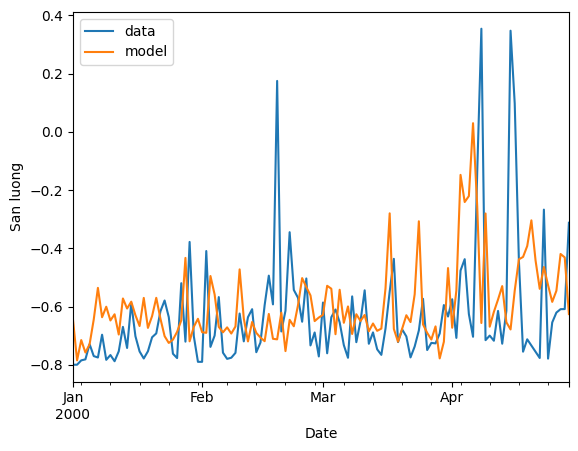

In [13]:
trainETS.iloc[:120].plot(label='data')
best_model.fittedvalues.iloc[:120].plot(label='model')
plt.ylabel("San luong")
plt.legend()

Dự đoán trên tập Val

Validation set
Kết quả đánh giá:
MSE: 19.01747213990402
RMSE: 4.360902674894731
MAE: 3.059655902658142
MAPE: 0.6000702965613189
R2: -7.195593329653862


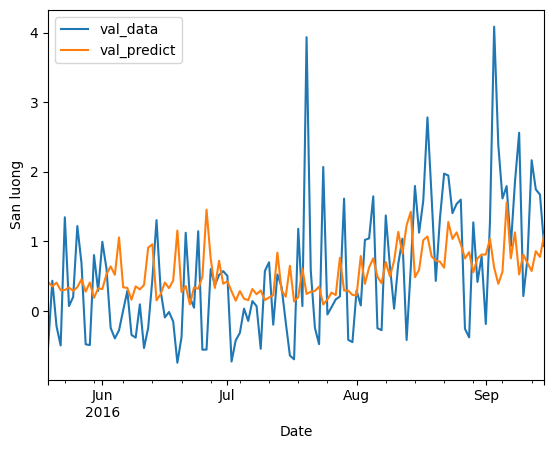

In [14]:
valETS_pred = best_model.predict(start=valETS.index[0], end=valETS.index[-1])
valETS_pred_unscale = scaler.inverse_transform(valETS_pred.values.reshape(-1,1))
valETS_unscale = scaler.inverse_transform(valETS.values.reshape(-1,1))

valETS.iloc[:120].plot(label='val_data')
valETS_pred.iloc[:120].plot(label='val_predict')
plt.ylabel("San luong")
plt.legend()

print('Validation set')
get_metrics(valETS_pred_unscale,valETS_unscale)

Dự đoán trên tập test

Test set
Kết quả đánh giá:
MSE: 27.462417753858897
RMSE: 5.240459689174118
MAE: 3.5512870984388587
MAPE: 0.5897350357499427
R2: -9.640691089070538


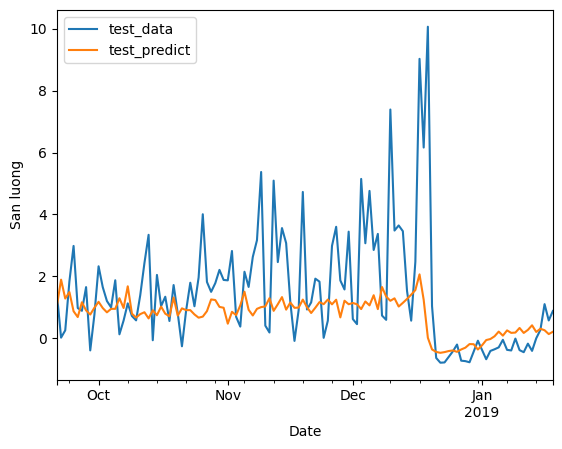

In [23]:
testETS_pred=best_model.predict(start=testETS.index[0], end=testETS.index[-1])
testETS_pred_unscale = scaler.inverse_transform(testETS_pred.values.reshape(-1,1)).flatten()
testETS_unscale = scaler.inverse_transform(testETS.values.reshape(-1,1)).flatten()

testETS.iloc[:120].plot(label='test_data')
testETS_pred.iloc[:120].plot(label='test_predict')
plt.ylabel("San luong")
plt.legend()

print('Test set')
get_metrics(testETS_pred_unscale,testETS_unscale)

Dự đoán 30 ngày trong tương lai

In [26]:
future_pred = best_model.predict(start=testETS.index[-1], end=testETS.index[-1] + pd.DateOffset(days=30))
future_pred_unscale = scaler.inverse_transform(future_pred.values.reshape(-1,1)).flatten()
future_pred_unscale

array([ 6.0440325 ,  6.53550732,  5.71744318,  6.22104063,  6.18656847,
        6.98545513,  7.39700979,  6.94838969,  8.94911613,  6.278068  ,
        6.245375  ,  5.61429216,  6.32820693,  6.16670151,  6.40187854,
        8.39765655,  8.5831395 ,  5.58067421,  5.91647551,  6.53487066,
        6.23178016,  6.64498937,  9.31636165,  6.02520771,  6.35127686,
        5.36463332,  6.27397728,  6.20166043,  6.83685183, 10.43364308,
        7.80757703])

## Linear Regression (LR) (Tài)

In [285]:
from sklearn.linear_model import LinearRegression

model_LR = LinearRegression()
model_LR.fit(X_train,y_train)

pred_val = model_LR.predict(X_val)
pred_test = model_LR.predict(X_test)

pred_val_unscale = scaler.inverse_transform(pred_val)
pred_test_unscale = scaler.inverse_transform(pred_test)

print('Validation set')
get_metrics(pred_val_unscale,y_val_unscale)

print('\nTest set')
get_metrics(pred_test_unscale,y_test_unscale)

Validation set
Kết quả đánh giá:
MSE: 17.40602907180373
RMSE: 4.172053339999829
MAE: 2.8933561807669133
MAPE: 0.7623794493692168
R2: -1.4662763721139997

Test set
Kết quả đánh giá:
MSE: 26.25486058568252
RMSE: 5.123949705616022
MAE: 3.4658986859854863
MAPE: 1.2465835822262588
R2: -1.8142795534739198


In [238]:
pred_30days = model_LR.predict(X_30days)
pred_30days_unscale = scaler.inverse_transform(pred_30days)
pred_30days_unscale

array([[3.76253257, 4.75294311, 4.89315827, 3.97762057, 4.00103629,
        3.91744223, 3.60327878, 4.04093651, 5.28444856, 4.75354933,
        4.2034936 , 3.46051499, 3.45887796, 3.7799605 , 3.58004423,
        4.7683015 , 4.08897231, 4.13110554, 3.79905556, 3.93604367,
        3.03303053, 3.19863387, 4.7129007 , 3.88069477, 3.56823908,
        3.04125422, 3.33832178, 2.68212788, 3.13751586, 4.17371994]])

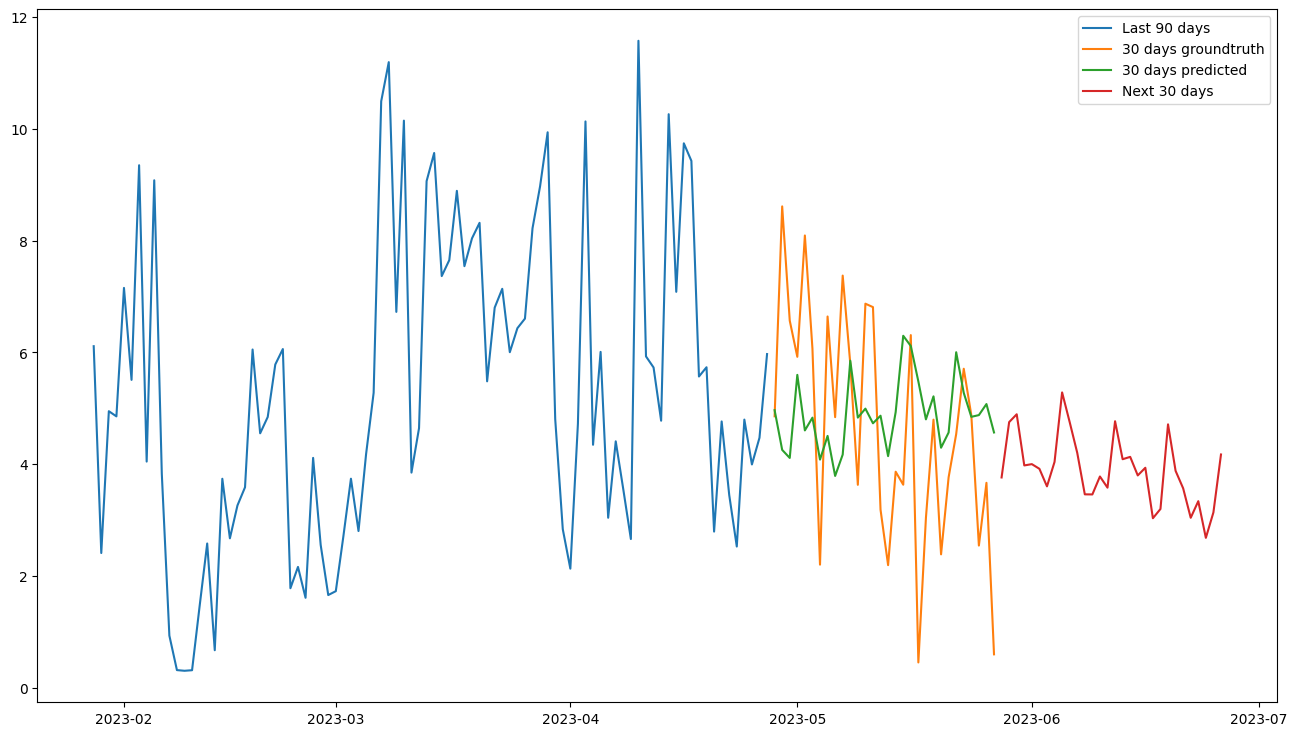

In [239]:
visualize(test,X_test_unscale,y_test_unscale,pred_30days_unscale)

In [284]:
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LinearRegression

parameters = {'C':[1, 10]}
modelLR = LinearRegression()
clf = GridSearchCV(modelLR, parameters)
clf.fit(X_train,y_train)

pred_val = clf.predict(X_val)
pred_test = clf.predict(X_test)

pred_val_unscale = scaler.inverse_transform(pred_val)
pred_test_unscale = scaler.inverse_transform(pred_test)

print('Validation set')
get_metrics(pred_val_unscale,y_val_unscale)

print('\nTest set')
get_metrics(pred_test_unscale,y_test_unscale)

ValueError: Invalid parameter 'C' for estimator LinearRegression(). Valid parameters are: ['copy_X', 'fit_intercept', 'n_jobs', 'normalize', 'positive'].

## Random Forest (RF) (regressor) (Ngọc Hiền)

### Import thư viện

In [240]:
from sklearn.preprocessing import MinMaxScaler, StandardScaler
import matplotlib.pyplot as plt
import random
import pandas as pd
import numpy as np
import datetime
import time
from sklearn.ensemble import RandomForestRegressor

In [290]:
model_RF = RandomForestRegressor(n_estimators = 30, random_state=42)
model_RF.fit(X_train,y_train)

RandomForestRegressor(n_estimators=30, random_state=42)

In [291]:
pred_val = model_RF.predict(X_val)
pred_test = model_RF.predict(X_test)

pred_val_unscale = scaler.inverse_transform(pred_val)
pred_test_unscale = scaler.inverse_transform(pred_test)

print('Validation set')
get_metrics(pred_val_unscale,y_val_unscale)

print('\nTest set')
get_metrics(pred_test_unscale,y_test_unscale)

Validation set
Kết quả đánh giá:
MSE: 18.790133069031967
RMSE: 4.334758709436082
MAE: 2.894980752729296
MAPE: 0.6591878230973335
R2: -5.861226102154674

Test set
Kết quả đánh giá:
MSE: 31.822695309935877
RMSE: 5.641160812274002
MAE: 3.547891651895685
MAPE: 0.8252816432551603
R2: -16.36384602108835


In [292]:
pred_30days = model_RF.predict(X_30days)
pred_30days_unscale = scaler.inverse_transform(pred_30days)
pred_30days_unscale

array([[3.1682    , 4.4644    , 4.04257   , 3.53762333, 3.74265333,
        3.59883167, 3.15501   , 3.80818167, 4.83981667, 4.10412333,
        3.55900667, 3.32559   , 3.99217667, 2.94652667, 3.98028667,
        4.53902667, 4.67434333, 3.53264   , 3.45563667, 3.68186667,
        3.41929222, 4.03542111, 3.12812   , 3.7512    , 3.11512   ,
        3.507135  , 3.560675  , 2.82312667, 4.31589   , 3.46211167]])

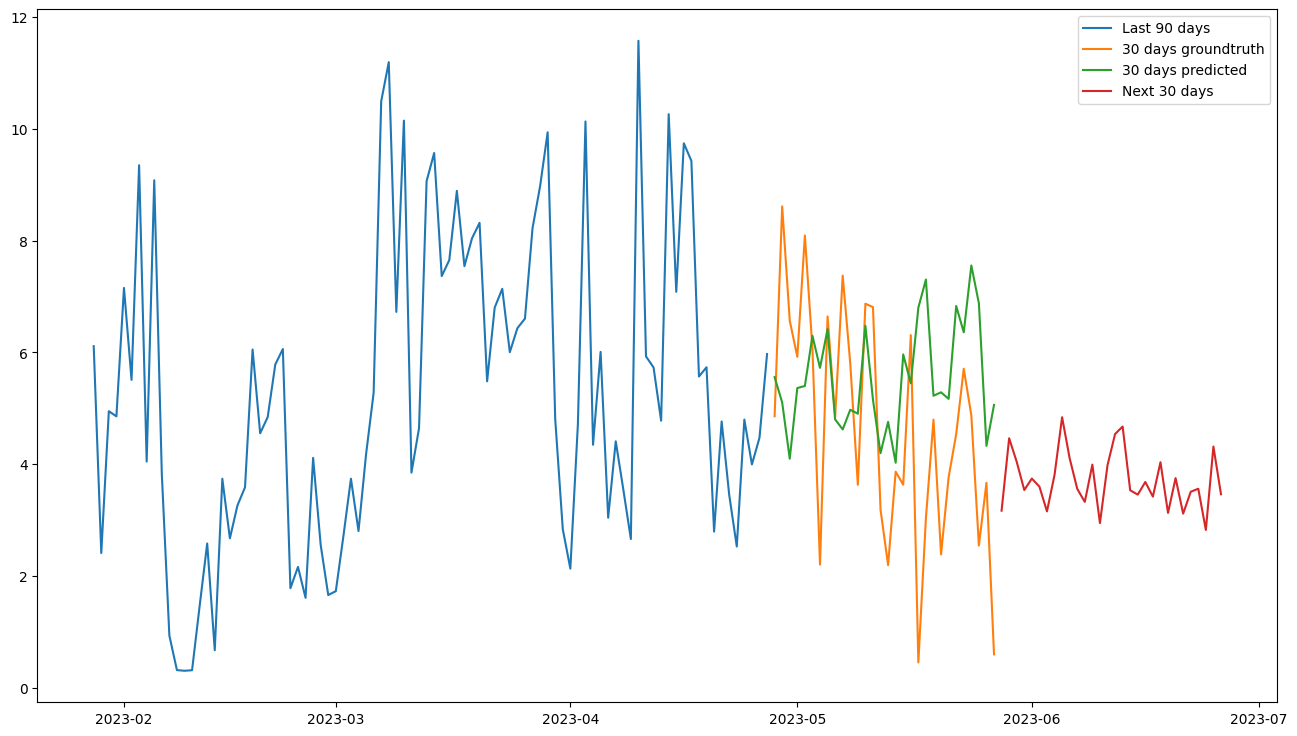

In [293]:
visualize(test,X_test_unscale,y_test_unscale,pred_30days_unscale)

In [245]:
1/0

ZeroDivisionError: division by zero

## AutoRegressive Integrated Moving Average (ARIMA) (Ngọc Hiền)

In [254]:
!pip install pmdarima

You should consider upgrading via the '/root/venv/bin/python -m pip install --upgrade pip' command.


In [259]:
from pmdarima.arima import auto_arima

x_train_arima = np.array(train.index).reshape(-1, 1)
y_train_arima = np.array(train['Product_weight'])

model = auto_arima(y_train_arima, trace=True, error_action='ignore', suppress_warnings=True)

model.fit(y_train_arima)

Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=15500.006, Time=12.66 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=18672.402, Time=0.20 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=17435.043, Time=0.52 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=15547.307, Time=3.80 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=18670.402, Time=0.30 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=15498.504, Time=12.59 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=15501.407, Time=6.40 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=15504.930, Time=3.81 sec
 ARIMA(1,1,3)(0,0,0)[0] intercept   : AIC=15500.144, Time=22.38 sec
 ARIMA(0,1,3)(0,0,0)[0] intercept   : AIC=15498.374, Time=12.11 sec
 ARIMA(0,1,4)(0,0,0)[0] intercept   : AIC=15499.618, Time=19.19 sec
 ARIMA(1,1,4)(0,0,0)[0] intercept   : AIC=15502.354, Time=11.70 sec
 ARIMA(0,1,3)(0,0,0)[0]             : AIC=15496.400, Time=4.71 sec
 ARIMA(0,1,2)(0,0,0)[0]             : AIC=15499.438, Time=2.50 sec
 ARIMA(1,1,3)

ARIMA(order=(0, 1, 3), scoring_args={}, suppress_warnings=True,
      with_intercept=False)

In [270]:
x_val_arima = np.array(val.index).reshape(-1, 1)
y_val_arima = np.array(val['Product_weight'])
y_pred_val_arima =  model.predict(n_periods=len(y_val_arima))

y_val_arima_unscale = scaler.inverse_transform(y_val_arima.reshape(-1,1)).flatten()
y_pred_val_arima_unscale = scaler.inverse_transform(y_pred_val_arima.reshape(-1,1)).flatten()

In [271]:
x_test_arima = np.array(test.index).reshape(-1, 1)
y_test_arima = np.array(test['Product_weight'])
y_pred_test_arima = model.predict(n_periods=len(y_test_arima))

y_test_arima_unscale = scaler.inverse_transform(y_test_arima.reshape(-1,1)).flatten()
y_pred_test_arima_unscale = scaler.inverse_transform(y_pred_test_arima.reshape(-1,1)).flatten()

In [272]:
print('Validation set')
get_metrics(y_pred_val_arima_unscale,y_val_arima_unscale)

print('\nTest set')
get_metrics(y_pred_test_arima,y_test_arima_unscale)

Validation set
Kết quả đánh giá:
MSE: 25.663548437996734
RMSE: 5.065920295266866
MAE: 3.3223602770514233
MAPE: 0.9053947796310572
R2: -5209577.994098174

Test set
Kết quả đánh giá:
MSE: 72.84688952620387
RMSE: 8.535038929390062
MAE: 6.253500458525384
MAPE: 33.76702639957211
R2: -409688262.1186884


## K-Nearest Neighbors (KNN) (Linh)

### Import and split data

In [280]:
from sklearn.neighbors import KNeighborsRegressor

# Implement thuật toán KNN
knn_model = KNeighborsRegressor(n_neighbors=20)

# Train mô hình
knn_model.fit(X_train, y_train)

KNeighborsRegressor(n_neighbors=20)

In [281]:
# Xem kết quả đánh giá
pred_val = knn_model.predict(X_val)
pred_test = knn_model.predict(X_test)

pred_val_unscale = scaler.inverse_transform(pred_val)
pred_test_unscale = scaler.inverse_transform(pred_test)

print('Validation set')
get_metrics(pred_val_unscale,y_val_unscale)

print('\nTest set')
get_metrics(pred_test_unscale,y_test_unscale)

Validation set
Kết quả đánh giá:
MSE: 20.355002374934372
RMSE: 4.511651845492333
MAE: 2.9940840435205867
MAPE: 0.7707448968920702
R2: -7.1353109195351045

Test set
Kết quả đánh giá:
MSE: 32.71900419684489
RMSE: 5.720052814165696
MAE: 3.629652264351078
MAPE: 0.9595029714941496
R2: -14.434055138633111


In [282]:
pred_30days = knn_model.predict(X_30days)
pred_30days_unscale = scaler.inverse_transform(pred_30days)
pred_30days_unscale

array([[2.640585  , 5.71716   , 5.67848   , 4.47133   , 3.778555  ,
        5.98842   , 2.801065  , 3.5241575 , 6.725275  , 5.66729   ,
        4.4601    , 4.346465  , 5.270345  , 2.820775  , 3.34558   ,
        5.973665  , 4.98428   , 4.20783667, 4.28471833, 3.99912   ,
        2.04881   , 2.98324   , 5.09587   , 5.04691   , 4.569215  ,
        6.83704   , 4.2155425 , 2.6207025 , 2.908185  , 5.361505  ]])

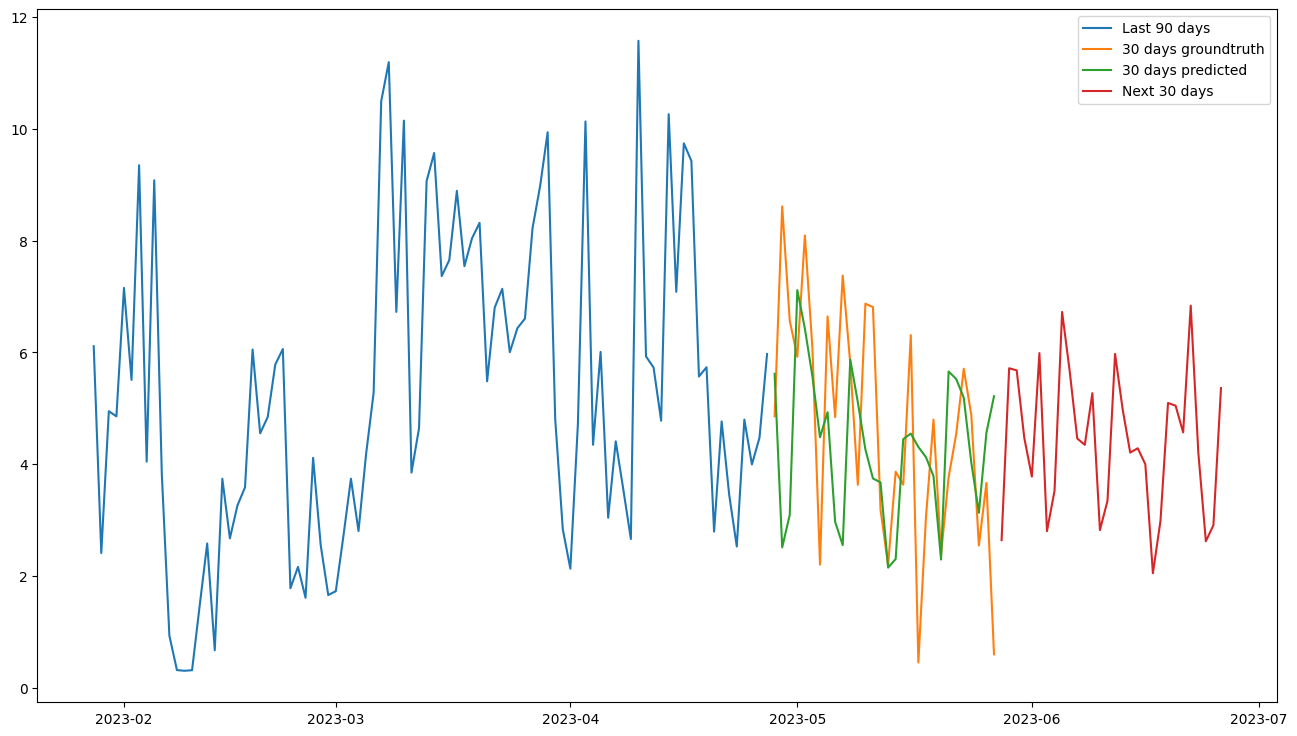

In [283]:
visualize(test,X_test_unscale,y_test_unscale,pred_30days_unscale)

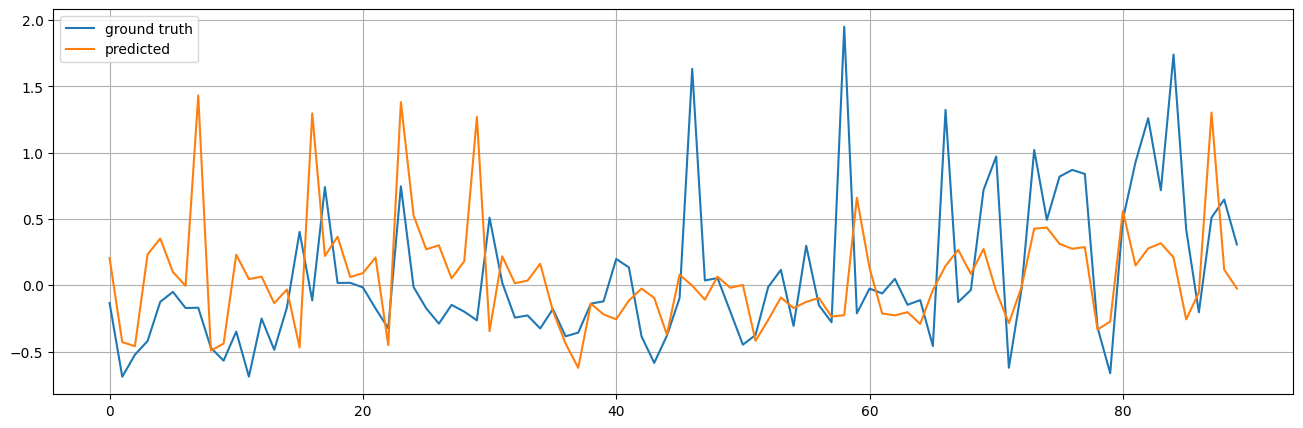

In [278]:
# Trực quan hóa dữ liệu
for i in range(1):
  plt.figure(figsize=(16,5))
  plt.plot(y_val[-90:,i])
  plt.plot(pred_val[-90:,i])
  plt.grid()
  plt.legend(['ground truth','predicted'])
  plt.show()

<a style='text-decoration:none;line-height:16px;display:flex;color:#5B5B62;padding:10px;justify-content:end;' href='https://deepnote.com?utm_source=created-in-deepnote-cell&projectId=6497519a-7ae1-4dc7-bd8e-97988e886612' target="_blank">
 </img>
Created in <span style='font-weight:600;margin-left:4px;'>Deepnote</span></a>